## 问题1  log process 能否体现SSA的好处

$$dX_t = (-xlogx + x)dt + x^2dW_t$$

在0附近表现不佳，可能出现奇异性，可能为负值

## 问题2 理解Canard模型

## 问题3 把Canrad模型改成$\tilde{Q_u} $

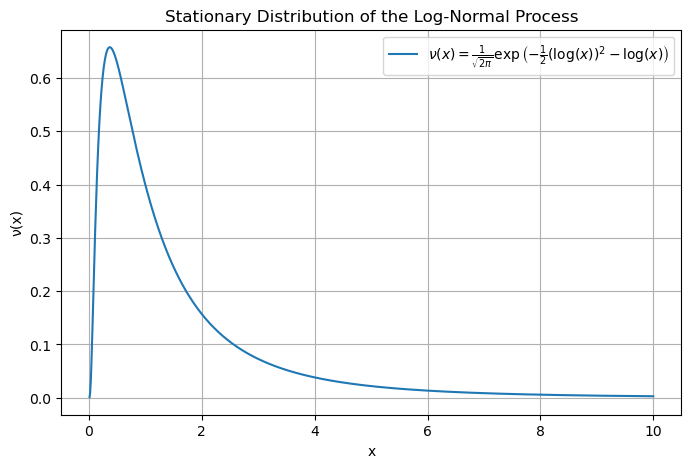

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the stationary distribution function
def nu(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (np.log(x))**2 - np.log(x))

# Generate x values
x_values = np.linspace(0.01, 10, 1000)  # Avoid x=0 to prevent log(0)

# Calculate the distribution values
nu_values = nu(x_values)

# Plot the stationary distribution
plt.figure(figsize=(8, 5))
plt.plot(x_values, nu_values, label=r"$\nu(x) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} (\log(x))^2 - \log(x)\right)$")
plt.title("Stationary Distribution of the Log-Normal Process")
plt.xlabel("x")
plt.ylabel("ν(x)")
plt.legend()
plt.grid(True)
plt.show()


# Canard

Website:[Canards](http://www.scholarpedia.org/article/Canards)

Video:[Canards in the van der Pol oscillator](https://www.youtube.com/watch?v=P1X2zkJDdUQ)





Equation of the Van der Pol oscillator: $$x^{''} + \mu(x^2-1)x'+ x = \alpha$$ 

where $\alpha$ is a constant forcing term and $\mu$ controls damping.

Consider the case where $\mu$ is large（$ \mu \gg 1 $）

After writing the equation as a system of first order ODE with appropriate changes of variable we obtain the standard form of a fast-slow system:
$$
\begin{cases}
    \varepsilon \dot{x} = y -\dfrac{x^3}{3} + x \\
    -x & \text{if } x < 0
\end{cases}
$$
where $0 < \varepsilon \ll 1$


Van der Pol oscillator as a fast-slow system:
\begin{cases}
    \varepsilon \dot{x} = y -\dfrac{x^3}{3} + x \\
    \dot{y} = a - x
\end{cases}

Let $\varepsilon = 0.04 $ and let us vary the parameter $\alpha$.

In blue, orbits with initial condition $(x(0), y(0)) = (2, 0)$

In red, the critical manifold (set of points where $ y - \frac{x^3}{3} + x = 0 $) with two outer attracting branches and one inner repelling branch delimited by the green dots

图中红色部分为临界流形（满足方程 $ y - \frac{x^3}{3} + x = 0 $ 的点集），包含两条外部吸引分支和一条内部排斥分支，其范围由绿色点标定

The gray arrows represent the relative magnitude of $\dot{x} $

![](canard.png)

![](canard1.png)

In [17]:
N = 600;     #NxN Grid 
eps = 0.3;   #Strength of noise # 0.5 original 
lowx = -3.0; #left end of numerical domain
lowy = -3.0; #bottom end of numerical domain
Sp = 6.0;    #length (and height) of the numerical domain
Sample = 10000000;#Sample size of Monte Carlo simulator
dt = 0.001;  #time step of numerical ODE scheme in MC simulator

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def canard(x):
    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    y = np.zeros(2)
    y[0] = (x[0] + x[1] - x[0]**3 / 3) / delta
    y[1] = a - x[0]
    return y

def MC_2D(lowx, lowy, Sp, N, eps, Sample, dt):
    h = Sp / N
    data = np.zeros(N * N)
    P = np.zeros((N, N))
    x_old = np.array([1.0, 1.0])  # initial point

    for _ in range(Sample):
        dW = np.sqrt(dt) * np.random.randn(2)
        drift = dt * canard(x_old)
        noise = eps * dW
        x_new = x_old + drift + noise

        xx, yy = x_new[0], x_new[1]
        x_n = int(np.ceil((xx - lowx) / h))
        y_n = int(np.ceil((yy - lowy) / h))

        if 1 <= x_n <= N and 1 <= y_n <= N:
            P[x_n - 1, y_n - 1] += 1  # index shift for 0-based Python

        x_old = x_new

    # Flatten P to 1D data vector
    for i in range(N):
        for j in range(N):
            data[i * N + j] = P[i, j]

    # Normalize to probability density
    total_count = np.sum(data)
    data1 = data / (h**2 * total_count)

    print(f"Sample Size = {Sample}")

    # Plot
    P_density = P / (h**2 * total_count)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(N) * h + lowx, np.arange(N) * h + lowy)
    ax.plot_surface(X, Y, P_density.T, cmap='viridis')
    ax.set_title("Monte Carlo Approximation (MC_2D)")
    plt.show()

    return data1


Sample Size = 100000


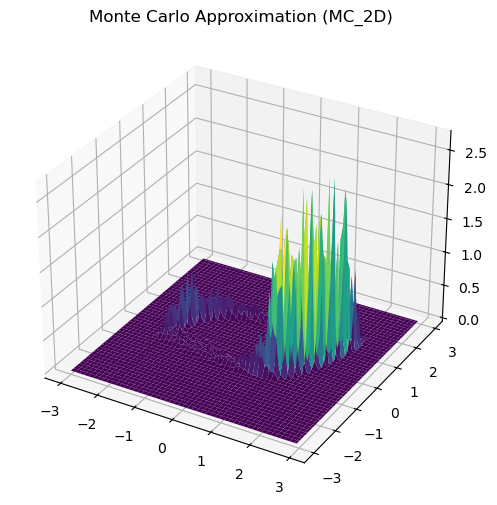

In [19]:
if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 100         # 更低的分辨率用于测试
    eps = 0.3
    Sample = 100000
    dt = 0.001

    density = MC_2D(lowx, lowy, Sp, N, eps, Sample, dt)


我们来逐行详细解释 `MC_2D` 这个函数，它实现了对 Canard 系统的 **Euler-Maruyama 方法的蒙特卡罗模拟**。

------

### 函数定义与参数

```matlab
function data1 = MC_2D(lowx, lowy, Sp, N, eps, Sample, dt)
```

**参数含义**：

| 参数           | 含义                               |
| -------------- | ---------------------------------- |
| `lowx`, `lowy` | 计算域的左下角坐标                 |
| `Sp`           | 区域的边长（假设是正方形）         |
| `N`            | 网格划分数，即 $N \times N$ 个格子 |
| `eps`          | 噪声强度（扩散项系数）             |
| `Sample`       | 蒙特卡罗模拟的样本数量             |
| `dt`           | Euler-Maruyama 时间步长            |

------

### 初始化

```matlab
h = Sp/N;                    % 每个格子的边长
data = zeros(N*N,1);         % 用于保存统计密度（展平的二维数据）
P = zeros(N,N);              % 用于累积每个格子的落点数
x_old = [1 1]';              % 初始位置（任意选定）
```

------

### 主循环：进行 Sample 次模拟

```matlab
for i = 1:Sample
    x_new = x_old + dt*canard(x_old) + eps*sqrt(dt)*randn(2,1);
```

这是 **Euler-Maruyama** 方法的离散格式：

$x_{\text{new}} = x_{\text{old}} + dt \cdot f(x_{\text{old}}) + \varepsilon \sqrt{dt} \cdot \mathcal{N}(0,1)$

- `canard(x_old)` 是确定性漂移项 $f(x)$
- `randn(2,1)` 是两个独立的一维标准正态变量，表示二维布朗运动
- `eps` 是噪声强度

------

### 将新位置映射到网格上并计数

```matlab
    xx = x_new(1);
    yy = x_new(2);
    x_n = ceil((xx - lowx)/h);
    y_n = ceil((yy - lowy)/h);
```

这几行代码将点 $(x, y)$ 投影到网格索引上。`ceil` 是向上取整，避免0索引。

```matlab
    if x_n >= 1 && x_n <=N && y_n >= 1 && y_n <= N
        P(x_n, y_n) = P(x_n,y_n) + 1;
    end
```

确保点落在边界内，并对落点格子做计数。

------

### 更新初值

```matlab
    x_old = x_new;   
```

准备进行下一步仿真。

------

### 把 2D 统计数据展平成 1D 向量

```matlab
for i = 1:N
    for j = 1:N
        data((i-1)*N + j) = P(i,j);
    end
end
```

这是把二维计数矩阵 $P \in \mathbb{R}^{N \times N}$ 展平为 $N^2$ 维向量，用于后续矩阵操作。

------

### 归一化为概率密度

```matlab
data1 = data/(h^2*sum(data)); % 归一化为概率密度
fprintf('Sample Size = %d\n',Sample);
```

- `sum(data)` 是总样本数（理论上等于 `Sample`）
- 除以 $h^2$ 是因为每个网格面积是 $h^2$，这是从“概率质量”转换为“密度”的关键步骤

------

### 可视化

```matlab
subplot(2,1,1)
P = P / (h^2 * sum(data));
mesh(P)
```

- 可视化结果：绘制概率密度的网格图
- 注意：`mesh(P)` 实际上绘制的是二维密度而非轨迹

------

### 总结

该函数以 **Euler-Maruyama 方法**为基础，完成了以下任务：

1. 生成 $\text{Sample}$ 条随机路径；
2. 在 $N \times N$ 网格上统计路径落点；
3. 计算经验密度 $\rho(x,y) \approx \frac{\text{count}}{h^2 \cdot \text{total count}}$；
4. 最终返回的是展平的一维密度向量 `data1`，用于数值解修正。



我们用网格上每个交叉点 \((x_i, y_j)\) 对应的密度值 \(P(i,j)\) 来近似函数 \(\rho(x, y)\) 的值，这就构成了一个**数值近似的概率密度函数图像**。

更准确地说：

- 每个 \(P(i,j)\) 表示落在以 \((x_i, y_j)\) 为中心的那一个网格小方块中的样本数量；
- 除以总样本数和网格面积 \(h^2\)，得到单位面积上的概率密度估计；
- 最终我们用这些离散点上的密度值绘制曲面图，近似展示真实的二维密度函数 \(\rho(x,y)\)。


### 对应的数学语言是：

我们将概率密度函数 $\rho(x, y)$的近似值定义为：

$$ \rho(x_i, y_j) \approx \frac{\text{Count}_{ij}}{h^2 \cdot \text{Total Samples}} $$

其中：

- $ \text{Count}_{ij}$ ：落在第 $(i,j)$ 个格子内的样本数
- $h^2$：每个格子的面积
- 总体积归一化成概率密度函数

所以 `plot_surface(X, Y, P_density.T)` 近似于画函数 \(\rho(x,y)\) 在二维区域上的图像。

![流程](density.png)



In [20]:
import numpy as np
import matplotlib.pyplot as plt

def SSA_2D(lowx, lowy, Sp, N, eps, Sample):
    h = Sp / N  # 网格步长
    data = np.zeros((N+1)*(N+1))  # 展平的密度数组
    P = np.zeros((N+1, N+1))      # 累积频数
    
    # 初始状态（注意，这里是连续变量，不是索引）
    x, y = 1.0, 1.0  # 初始点
    t = 0.0  # 时间初始化
    t_stop = 50000  # 最大模拟时间
    n = 0   # 当前模拟步数

    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    sigma = eps
    M_11 = sigma**2 / 2
    M_22 = sigma**2 / 2
    C1 = M_11 / h**2
    C2 = M_22 / h**2

    while t < t_stop:
        mu_1 = (y - x**3 / 3 + x) / delta
        mu_2 = a - x

        # 四个通道的速率（偏移布朗运动 + 漂移项）
        q1 = max(mu_1, 0) / h + C1  # 右
        q2 = -min(mu_1, 0) / h + C1 # 左
        q3 = max(mu_2, 0) / h + C2  # 上
        q4 = -min(mu_2, 0) / h + C2 # 下

        lambda_sum = q1 + q2 + q3 + q4
        r = np.random.rand(2)
        tau = -np.log(r[0]) / lambda_sum

        direction_probs = np.cumsum([q1, q2, q3, q4])
        mu_number = np.searchsorted(direction_probs, r[1] * lambda_sum) + 1

        t += tau

        # 执行跳跃
        if mu_number == 4:
            x += h
        elif mu_number == 3:
            x -= h
        elif mu_number == 2:
            y += h
        elif mu_number == 1:
            y -= h

        # 投影到网格
        x_n = int(round((x - lowx) / h))
        y_n = int(round((y - lowy) / h))
        if 1 <= x_n <= N and 1 <= y_n <= N:
            P[x_n, y_n] += 1

        n += 1
        if n == Sample:
            break

    # 展平数据
    for i in range(N+1):
        for j in range(N+1):
            data[i * (N+1) + j] = P[i, j]

    # 归一化为概率密度
    data2 = data / (h**2 * np.sum(data))

    print(f"Sample Size = {n}")

    # 可视化
    P_density = P / (h**2 * np.sum(P))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(N+1) * h + lowx, np.arange(N+1) * h + lowy)
    ax.plot_surface(X, Y, P_density.T, cmap='plasma')
    ax.set_title("SSA Approximation (SSA_2D)")
    plt.show()

    return data2


Sample Size = 100000


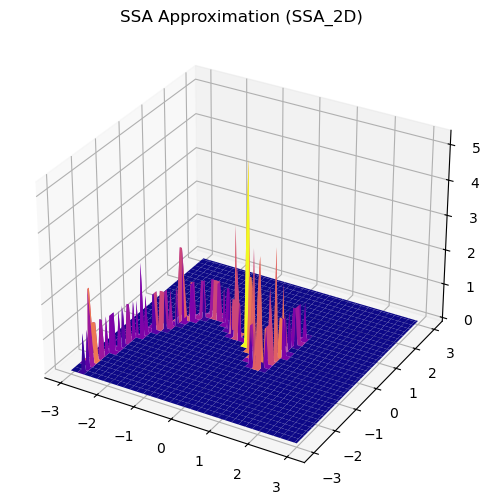

In [21]:
if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 100        # 网格分辨率
    eps = 0.3
    Sample = 100000
    density = SSA_2D(lowx, lowy, Sp, N, eps, Sample)


这是一个 基于跳跃过程的随机模拟算法，类似于 Gillespie 算法，用来模拟二维快慢系统在网格上的随机行为，估计其稳态概率密度




![](SSA.png)

### Sample rejection

When using stochastic simulation methods—whether it's the **Stochastic Simulation Algorithm (SSA)** or **Monte Carlo simulations (like Euler-Maruyama)**—the issue of **sample rejection** can arise in various forms. Here's what happens when samples are rejected or fall outside the valid domain:

This line enforces rejection:
  ```matlab
  if x_n >= 1 && x_n <= N && y_n >= 1 && y_n <= N
      P(x_n, y_n) = P(x_n,y_n) + 1;
  end
  ```
If the simulated point falls outside the domain, it’s **ignored**.

This can lead to **underestimation** of boundary densities, and if many samples fall out, it **reduces accuracy** and creates a **biased probability density function**.


### 构建求解稳态方程的系数矩阵

主程序的核心逻辑大致如下：

第一步： 定义参数，使用SSA_2D产生稳态分布数据。

第二步： 根据SSA_2D输出结果data2，构造并求解线性系统：

$$ Ax = b- A*data2 $$

第三步： 使用lsqminnorm（最小范数法）求得线性系统的最优解 $x$，并计算最终解y。

第四步： 将最终解y与data2分别以三维网格形式绘制出来比较结果。

In [22]:
import numpy as np
from scipy.sparse import coo_matrix

def canard(x):
    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    y = np.zeros(2)
    y[0] = (x[0] + x[1] - x[0]**3 / 3) / delta
    y[1] = a - x[0]
    return y

def Matrix_2D(lowx, lowy, Sp, N, eps0):
    eps = eps0**2 / 2  # Diffusion coefficient
    h = Sp / N         # Grid spacing
    n_nodes = (N+1) * (N+1)  # Total number of grid points
    
    # Initialize lists for sparse matrix construction
    row_indices = []
    col_indices = []
    values = []
    
    # Right-hand side vector
    b = np.zeros((N-1)*(N-1) + 1)
    b[(N-1)*(N-1)] = 1 / h**2  # Normalization row

    # Build the sparse matrix A
    for i in range(2, N):
        for j in range(2, N):
            # Grid point (xx, yy)
            xx = (i-1) * h + lowx
            yy = (j-1) * h + lowy
            
            # Central node index
            center_index = (i-2)*(N-1) + (j-1)
            
            # Drift terms
            f1 = canard([xx+h, yy])[0]  # f1 at (x+h, y)
            f2 = canard([xx, yy+h])[1]  # f2 at (x, y+h)

            # Right (x+h, y)
            row_indices.append(center_index)
            col_indices.append((i-1)*(N+1) + (N+1) + j)
            values.append(-f1/(2*h) + eps/(h**2))
            
            # Left (x-h, y)
            row_indices.append(center_index)
            col_indices.append((i-1)*(N+1) - (N+1) + j)
            values.append(f1/(2*h) + eps/(h**2))

            # Up (x, y+h)
            row_indices.append(center_index)
            col_indices.append((i-1)*(N+1) + j + 1)
            values.append(-f2/(2*h) + eps/(h**2))

            # Down (x, y-h)
            row_indices.append(center_index)
            col_indices.append((i-1)*(N+1) + j - 1)
            values.append(f2/(2*h) + eps/(h**2))

            # Center (x, y)
            row_indices.append(center_index)
            col_indices.append((i-1)*(N+1) + j)
            values.append(-4*eps/(h**2))
    
    # Normalization row (last row)
    for i in range(N+1):
        for j in range(N+1):
            row_indices.append((N-1)*(N-1))
            col_indices.append(i*(N+1) + j)
            values.append(1)

    # Construct sparse matrix
    A = coo_matrix((values, (row_indices, col_indices)), shape=((N-1)*(N-1) + 1, (N+1)*(N+1)))
    
    return A, b


In [23]:
if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 100
    eps0 = 0.3
    
    A, b = Matrix_2D(lowx, lowy, Sp, N, eps0)
    print(f"Matrix A shape: {A.shape}")
    print(f"Vector b shape: {b.shape}")


Matrix A shape: (9802, 10201)
Vector b shape: (9802,)


Running SSA_2D simulation...
Sample Size = 10000000


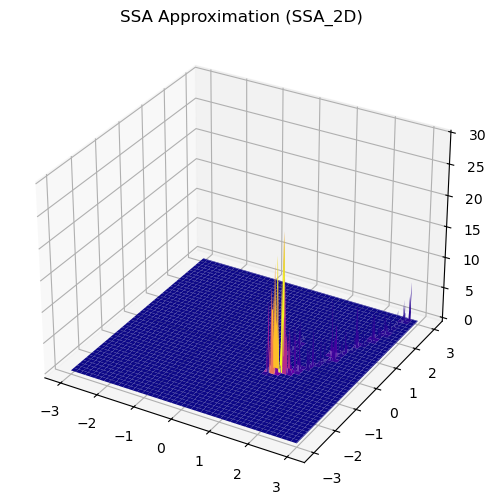

Building matrix...
Solving least-norm correction...
Visualizing results...


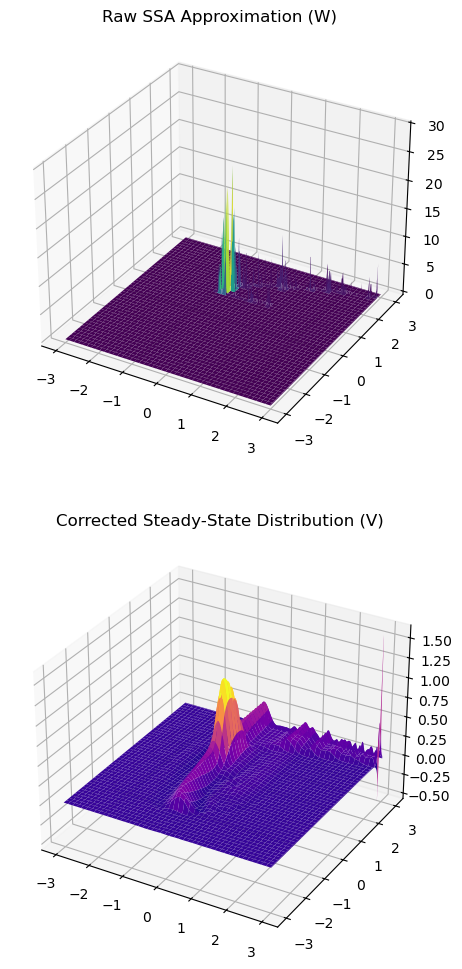

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

# Simulation parameters
N = 600
eps = 0.3
lowx = -3.0
lowy = -3.0
Sp = 6.0
Sample = 10000000
dt = 0.001

# Generate approximate data using SSA
print("Running SSA_2D simulation...")
data2 = SSA_2D(lowx, lowy, Sp, N, eps, Sample)

# Build matrix for correction step
print("Building matrix...")
A, b = Matrix_2D(lowx, lowy, Sp, N, eps)

# Apply correction step
b = b - A @ data2
print("Solving least-norm correction...")
x = lsqr(A, b)[0]
y = x + data2

# Reshape the final solutions for visualization
V = np.zeros((N+1, N+1))
W = np.zeros((N+1, N+1))
for i in range(N+1):
    for j in range(N+1):
        V[i, j] = y[i * (N+1) + j]
        W[i, j] = data2[i * (N+1) + j]

# Visualization
print("Visualizing results...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), subplot_kw={"projection": "3d"})

# Plot raw SSA solution
X, Y = np.meshgrid(np.linspace(lowx, lowx + Sp, N+1), np.linspace(lowy, lowy + Sp, N+1))
ax1.plot_surface(X, Y, W, cmap='viridis')
ax1.set_title("Raw SSA Approximation (W)")

# Plot corrected solution
ax2.plot_surface(X, Y, V, cmap='plasma')
ax2.set_title("Corrected Steady-State Distribution (V)")

plt.show()



## 使用 $\tilde{Q}_u$ scheme

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def SSA_2D(lowx, lowy, Sp, N, eps, Sample):
    h = Sp / N  # 网格步长
    data = np.zeros((N+1)*(N+1))  # 展平的密度数组
    P = np.zeros((N+1, N+1))      # 累积频数
    
    # 初始状态（注意，这里是连续变量，不是索引）
    x, y = 1.0, 1.0  # 初始点
    t = 0.0  # 时间初始化
    t_stop = 50000  # 最大模拟时间
    n = 0   # 当前模拟步数

    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    sigma = eps
    # M_11 = (sigma**2 - max(np.abs(mu_1)*h, 0)) / 2
    # M_22 = (sigma**2 - max(np.abs(mu_2)*h, 0))/ 2
    # C1 = M_11 / h**2
    # C2 = M_22 / h**2

    while t < t_stop:
        mu_1 = (y - x**3 / 3 + x) / delta
        mu_2 = a - x
        M_11 = (sigma**2 - max(np.abs(mu_1)*h, 0)) / 2
        M_22 = (sigma**2 - max(np.abs(mu_2)*h, 0))/ 2
        C1 = M_11 / h**2
        C2 = M_22 / h**2

        # 四个通道的速率（偏移布朗运动 + 漂移项）
        q1 = max(mu_1, 0) / h + C1  # 右
        q2 = -min(mu_1, 0) / h + C1 # 左
        q3 = max(mu_2, 0) / h + C2  # 上
        q4 = -min(mu_2, 0) / h + C2 # 下

        lambda_sum = q1 + q2 + q3 + q4
        r = np.random.rand(2)
        tau = -np.log(r[0]) / lambda_sum

        direction_probs = np.cumsum([q1, q2, q3, q4])
        mu_number = np.searchsorted(direction_probs, r[1] * lambda_sum) + 1

        t += tau

        # 执行跳跃
        if mu_number == 4:
            x += h
        elif mu_number == 3:
            x -= h
        elif mu_number == 2:
            y += h
        elif mu_number == 1:
            y -= h

        # 投影到网格
        x_n = int(round((x - lowx) / h))
        y_n = int(round((y - lowy) / h))
        if 1 <= x_n <= N and 1 <= y_n <= N:
            P[x_n, y_n] += 1

        n += 1
        if n == Sample:
            break

    # 展平数据
    for i in range(N+1):
        for j in range(N+1):
            data[i * (N+1) + j] = P[i, j]

    # 归一化为概率密度
    data2 = data / (h**2 * np.sum(data))

    print(f"Sample Size = {n}")

    # 可视化
    P_density = P / (h**2 * np.sum(P))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(N+1) * h + lowx, np.arange(N+1) * h + lowy)
    ax.plot_surface(X, Y, P_density.T, cmap='plasma')
    ax.set_title("SSA Approximation (SSA_2D)")
    plt.show()

    return data2


Sample Size = 100000


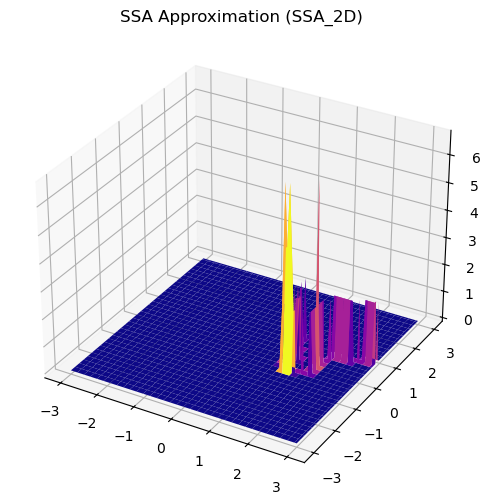

In [26]:
if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 100        # 网格分辨率
    eps = 0.3
    Sample = 100000
    density = SSA_2D(lowx, lowy, Sp, N, eps, Sample)

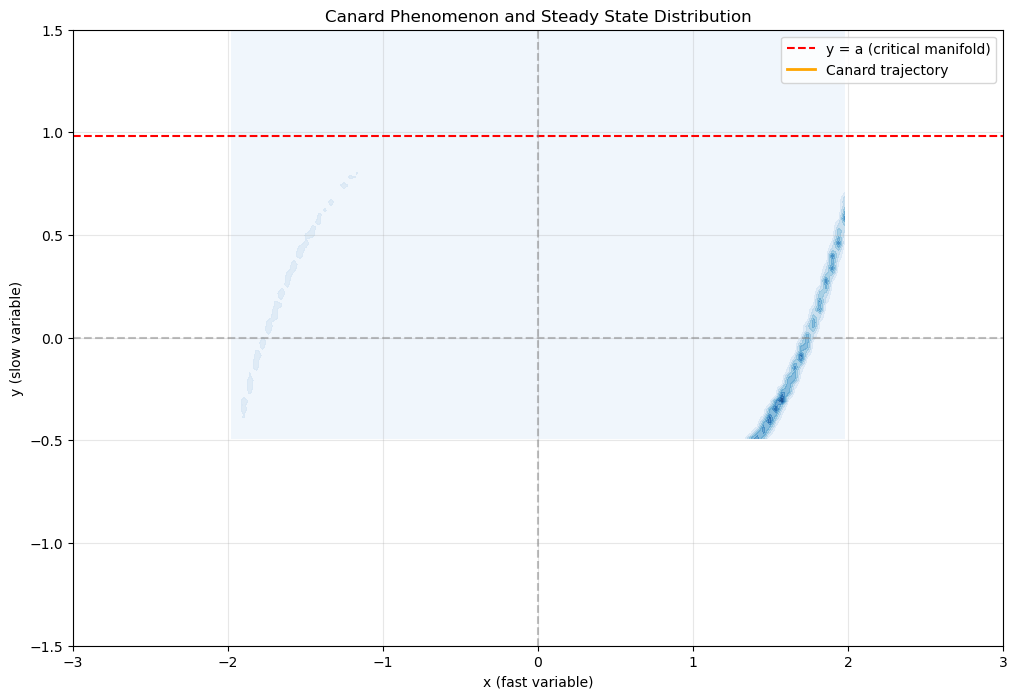

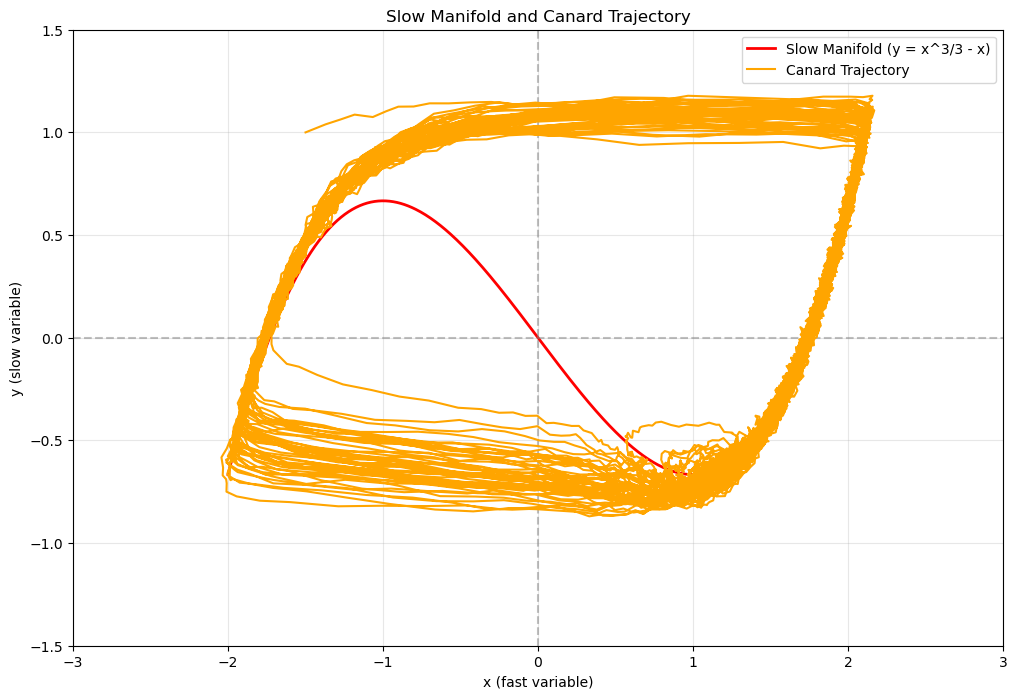

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
delta = 0.05
a = 1 - delta / 8 - 3 * delta**2 / 32 - 173 * delta**3 / 1024 - 0.01
sigma = 0.1
t_max = 200
dt = 0.01
n_steps = int(t_max / dt)

# Initial conditions
x = np.zeros(n_steps)
y = np.zeros(n_steps)
x[0] = -1.5
y[0] = 1.0

# Prepare histogram for steady state distribution
x_bins = np.linspace(-2, 2, 100)
y_bins = np.linspace(-0.5, 1.5, 100)
hist2d = np.zeros((len(x_bins)-1, len(y_bins)-1))

# Simulate the system
for i in range(1, n_steps):
    dx = (y[i-1] - (x[i-1]**3) / 3 + x[i-1]) / delta * dt + sigma * np.sqrt(2 * dt) * np.random.randn()
    dy = (a - x[i-1]) * dt + sigma * np.sqrt(2 * dt) * np.random.randn()
    x[i] = x[i-1] + dx
    y[i] = y[i-1] + dy
    
    # Update histogram
    x_idx = np.digitize(x[i], x_bins) - 1
    y_idx = np.digitize(y[i], y_bins) - 1
    if 0 <= x_idx < len(x_bins)-1 and 0 <= y_idx < len(y_bins)-1:
        hist2d[x_idx, y_idx] += 1

# Normalize histogram to get steady state distribution
steady_state = hist2d / np.sum(hist2d)

# Plot the steady state distribution and the Canard trajectory
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-3, 3)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Canard Phenomenon and Steady State Distribution")
ax.set_xlabel("x (fast variable)")
ax.set_ylabel("y (slow variable)")
ax.axhline(a, color='red', linestyle='--', label="y = a (critical manifold)")
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Plot steady state distribution
X, Y = np.meshgrid((x_bins[:-1] + x_bins[1:]) / 2, (y_bins[:-1] + y_bins[1:]) / 2)
ax.contourf(X, Y, steady_state.T, cmap='Blues', alpha=0.7)

# Prepare the trajectory line
line, = ax.plot([], [], lw=2, color='orange', label="Canard trajectory")
ax.legend()
ax.grid(True, alpha=0.3)

# Animation function
def animate(i):
    line.set_data(x[:i], y[:i])
    return line,

ani = animation.FuncAnimation(fig, animate, frames=n_steps, interval=20, blit=True)
plt.show()


# Define the slow manifold equation
x_vals = np.linspace(-2, 2, 500)
slow_manifold = (1/3) * x_vals**3 - x_vals

# Plot the slow manifold along with a typical Canard trajectory
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_vals, slow_manifold, color='red', linewidth=2, label="Slow Manifold (y = x^3/3 - x)")
ax.set_xlim(-3, 3)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Slow Manifold and Canard Trajectory")
ax.set_xlabel("x (fast variable)")
ax.set_ylabel("y (slow variable)")
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Add the trajectory for comparison
ax.plot(x, y, color='orange', linewidth=1.5, label="Canard Trajectory")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


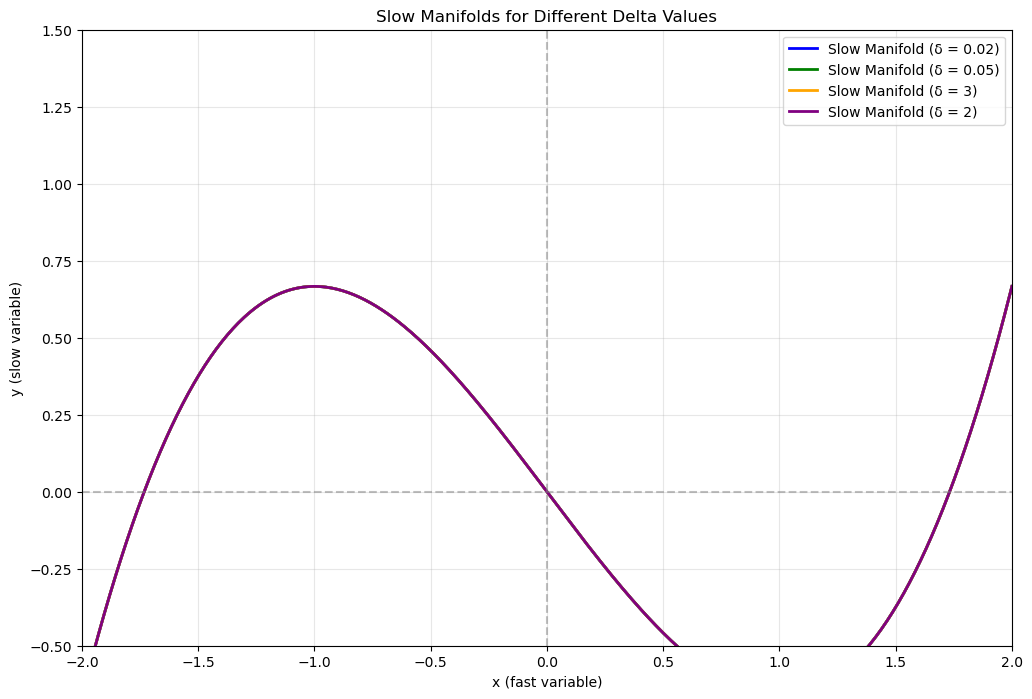

In [28]:
# Different delta values for comparison
delta_values = [0.02, 0.05, 3, 2]
colors = ["blue", "green", "orange", "purple"]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the slow manifolds for different delta values
for i, delta in enumerate(delta_values):
    a = 1 - delta / 8 - 3 * delta**2 / 32 - 173 * delta**3 / 1024 - 0.01
    slow_manifold = (1/3) * x_vals**3 - x_vals
    ax.plot(x_vals, slow_manifold, color=colors[i], linewidth=2, label=f"Slow Manifold (δ = {delta})")

ax.set_xlim(-2, 2)
ax.set_ylim(-0.5, 1.5)
ax.set_title("Slow Manifolds for Different Delta Values")
ax.set_xlabel("x (fast variable)")
ax.set_ylabel("y (slow variable)")
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


1. mean holding 

2.3. canard的相关理论；网格 sample = 10^8 N = 1000 画热力图，然后做差；差异点是快速变化区域

ssa 处理变步长；

4. 使用dt来求平均
   

In [29]:
# 使用sample = 10^8; N = 1000

import numpy as np
import matplotlib.pyplot as plt

def canard(x):
    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    y = np.zeros(2)
    y[0] = (x[0] + x[1] - x[0]**3 / 3) / delta
    y[1] = a - x[0]
    return y

def MC_2D(lowx, lowy, Sp, N, eps, Sample, dt):
    h = Sp / N
    data = np.zeros(N * N)
    P = np.zeros((N, N))
    x_old = np.array([1.0, 1.0])  # initial point

    for _ in range(Sample):
        dW = np.sqrt(dt) * np.random.randn(2)
        drift = dt * canard(x_old)
        noise = eps * dW
        x_new = x_old + drift + noise

        xx, yy = x_new[0], x_new[1]
        x_n = int(np.ceil((xx - lowx) / h))
        y_n = int(np.ceil((yy - lowy) / h))

        if 1 <= x_n <= N and 1 <= y_n <= N:
            P[x_n - 1, y_n - 1] += 1  # index shift for 0-based Python

        x_old = x_new

    # Flatten P to 1D data vector
    for i in range(N):
        for j in range(N):
            data[i * N + j] = P[i, j]

    # Normalize to probability density
    total_count = np.sum(data)
    data1 = data / (h**2 * total_count)

    print(f"Sample Size = {Sample}")

    # Plot
    P_density = P / (h**2 * total_count)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(N) * h + lowx, np.arange(N) * h + lowy)
    ax.plot_surface(X, Y, P_density.T, cmap='viridis')
    ax.set_title("Monte Carlo Approximation (MC_2D)")
    plt.show()

    return data1




Sample Size = 10000000


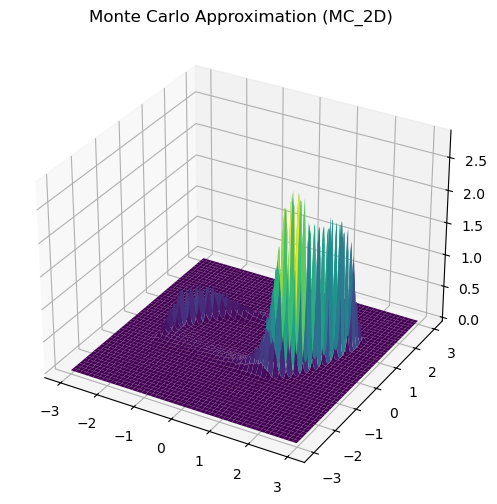

In [30]:
if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 600         
    eps = 0.3
    Sample = 10**7
    dt = 0.001

    density = MC_2D(lowx, lowy, Sp, N, eps, Sample, dt)


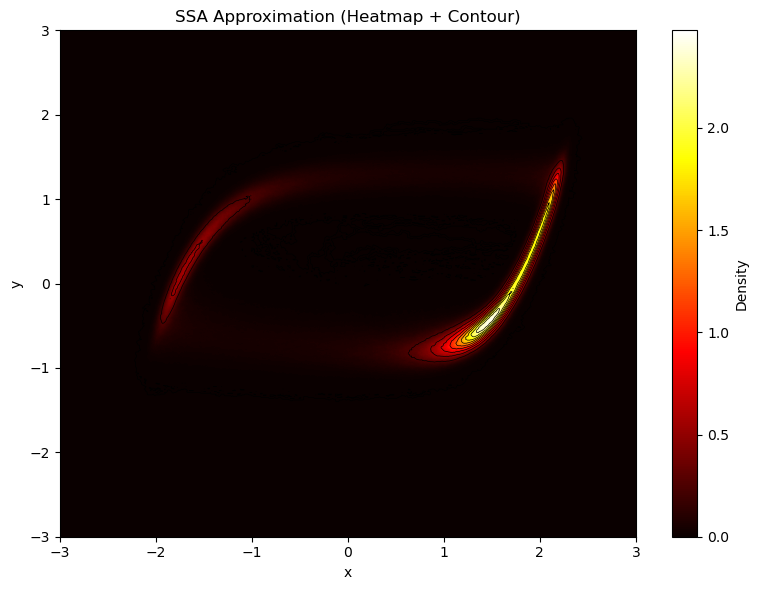

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def SSA_2D_accelerated(lowx, lowy, Sp, N, eps, Sample, t_stop=50000.0):
    h = Sp / N
    P = np.zeros((N + 1, N + 1), dtype=np.int64)

    # Initial state
    x, y = 1.0, 1.0
    t = 0.0
    n = 0

    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    sigma = eps
    M_11 = sigma**2 / 2
    M_22 = sigma**2 / 2
    C1 = M_11 / h**2
    C2 = M_22 / h**2

    while t < t_stop and n < Sample:
        mu_1 = (y - x**3 / 3 + x) / delta
        mu_2 = a - x

        q1 = max(mu_1, 0) / h + C1
        q2 = -min(mu_1, 0) / h + C1
        q3 = max(mu_2, 0) / h + C2
        q4 = -min(mu_2, 0) / h + C2

        lambda_sum = q1 + q2 + q3 + q4
        r1 = np.random.rand()
        r2 = np.random.rand()
        tau = -np.log(r1) / lambda_sum

        direction = r2 * lambda_sum
        if direction < q1:
            x += h
        elif direction < q1 + q2:
            x -= h
        elif direction < q1 + q2 + q3:
            y += h
        else:
            y -= h

        x_n = int(round((x - lowx) / h))
        y_n = int(round((y - lowy) / h))

        if 1 <= x_n <= N and 1 <= y_n <= N:
            P[x_n, y_n] += 1

        t += tau
        n += 1

    return P, n

def SSA_2D(lowx, lowy, Sp, N, eps, Sample):
    P, actual_samples = SSA_2D_accelerated(lowx, lowy, Sp, N, eps, Sample)

    h = Sp / N
    density = P / (h**2 * np.sum(P))

    # 可视化
    extent = [lowx, lowx + Sp, lowy, lowy + Sp]
    X, Y = np.meshgrid(np.linspace(lowx, lowx + Sp, N + 1),
                       np.linspace(lowy, lowy + Sp, N + 1))

    plt.figure(figsize=(8, 6))
    plt.imshow(density.T, origin='lower', extent=extent, cmap='hot', aspect='auto')
    plt.colorbar(label='Density')
    plt.contour(X, Y, density.T, levels=10, colors='black', linewidths=0.5)
    plt.title("SSA Approximation (Heatmap + Contour)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

    # 返回展平结果
    data_flat = density.flatten()
    return data_flat

if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 600
    eps = 0.3
    Sample = 10**8
    dt = 0.001

    density = SSA_2D(lowx, lowy, Sp, N, eps, Sample)


## 用时间权重代替次数权重进行模拟

$$ \langle f \rangle_{\pi} \approx \frac{1}{\sum_j \tau_j} \sum_j f(X_j) \tau_j $$

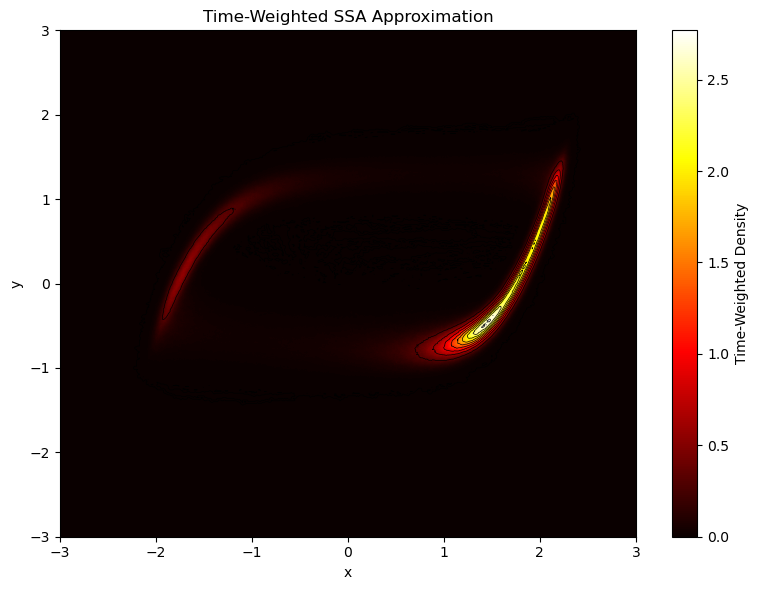

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def SSA_2D_time_weighted(lowx, lowy, Sp, N, eps, Sample, t_stop=50000.0):
    h = Sp / N
    T = np.zeros((N + 1, N + 1), dtype=np.float64)  # time-weighted histogram

    x, y = 1.0, 1.0
    t = 0.0
    n = 0

    delta = 0.1
    a = 1 - delta/8 - 3*delta**2/32 - 173*delta**3/1024 - 0.01
    sigma = eps
    M_11 = sigma**2 / 2
    M_22 = sigma**2 / 2
    C1 = M_11 / h**2
    C2 = M_22 / h**2

    while t < t_stop and n < Sample:
        mu_1 = (y - x**3 / 3 + x) / delta
        mu_2 = a - x

        q1 = max(mu_1, 0) / h + C1
        q2 = -min(mu_1, 0) / h + C1
        q3 = max(mu_2, 0) / h + C2
        q4 = -min(mu_2, 0) / h + C2

        lambda_sum = q1 + q2 + q3 + q4
        r1 = np.random.rand()
        r2 = np.random.rand()
        tau = -np.log(r1) / lambda_sum

        x_n = int(round((x - lowx) / h))
        y_n = int(round((y - lowy) / h))

        if 0 <= x_n <= N and 0 <= y_n <= N:
            T[x_n, y_n] += tau  # accumulate time instead of count

        direction = r2 * lambda_sum
        if direction < q1:
            x += h
        elif direction < q1 + q2:
            x -= h
        elif direction < q1 + q2 + q3:
            y += h
        else:
            y -= h

        t += tau
        n += 1

    return T, t

def SSA_2D(lowx, lowy, Sp, N, eps, Sample):
    T, total_time = SSA_2D_time_weighted(lowx, lowy, Sp, N, eps, Sample)

    h = Sp / N
    density = T / (h**2 * total_time)  # normalize using total simulation time

    # Visualization
    extent = [lowx, lowx + Sp, lowy, lowy + Sp]
    X, Y = np.meshgrid(np.linspace(lowx, lowx + Sp, N + 1),
                       np.linspace(lowy, lowy + Sp, N + 1))

    plt.figure(figsize=(8, 6))
    plt.imshow(density.T, origin='lower', extent=extent, cmap='hot', aspect='auto')
    plt.colorbar(label='Time-Weighted Density')
    plt.contour(X, Y, density.T, levels=10, colors='black', linewidths=0.5)
    plt.title("Time-Weighted SSA Approximation")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

    return density.flatten()

if __name__ == "__main__":
    lowx = -3.0
    lowy = -3.0
    Sp = 6.0
    N = 600
    eps = 0.3
    Sample = 10**8

    density = SSA_2D(lowx, lowy, Sp, N, eps, Sample)



$$
dX_t=-X_t^{3}\,dt+\sqrt{2}\,dW_t,\qquad x_i>x_j>0,
$$

可以用**解析方法**把三者联系起来：

$$
t^{\Delta}\;\text{(数值首达时间的均值)}\quad\text{vs}\quad 
\mathbb E[\tau]\;\text{(真实SDE的平均首达时间)}\quad\text{vs}\quad 
t^{e}\;\text{(漂移主导的ODE时间)}.
$$

下面给出一条**可计算的解析比较路线**，并写出显式公式与渐近展开。

---

# 1) 漂移主导的基准 $t^{e}$

当 $|x|$ 很大，噪声次要，先用 ODE $\dot x=-x^3$ 作为基准。由变量分离，

$$
t^{e}(x_i\!\to\! x_j)=\int_{x_i}^{x_j}\frac{-dx}{x^3}
=\frac12\Bigl(\frac1{x_j^2}-\frac1{x_i^2}\Bigr).
$$

---

# 2) 真实 SDE 的平均首达时间 $\mathbb E[\tau]$ 的解析表达

令 $u(x)=\mathbb E_x[\tau_{x_j}]$（从 $x>x_j$ 首次到达 $x_j$ 的平均时间）。生成元为

$$
\mathcal L u = u''(x)-x^3 u'(x),
$$

（因为 $\sigma^2/2=1$）。$u$ 满足边值问题

$$
u''(x)-x^3u'(x)=-1,\qquad u(x_j)=0,\qquad u \ \text{在}\ x\to\infty\ \text{适配自然边界（有界/增长受控）}.
$$

对上式做一个“校正”分解：令

$$
u'(x)=\frac{1}{x^3}+v(x),
$$

代回得一阶线性方程

$$
v'(x)-x^3 v(x)=\frac{3}{x^4}.
$$

用积分因子 $m(x)=e^{-\int x^3dx}=e^{-x^4/4}$ 解得

$$
v(x) = -\,e^{x^4/4}\int_{x}^{\infty}\frac{3}{y^4}\,e^{-y^4/4}\,dy.
$$

因此

$$
u'(x)=\frac{1}{x^3}\;-\;e^{x^4/4}\int_{x}^{\infty}\frac{3}{y^4}\,e^{-y^4/4}\,dy,
$$

而

$$
\boxed{\;
\mathbb E[\tau]=u(x_i)
= t^{e}\;+\;\int_{x_j}^{x_i}\!v(x)\,dx
= t^{e}\;-\;\int_{x_j}^{x_i}\!e^{x^4/4}\Bigl(\int_{x}^{\infty}\frac{3}{y^4}e^{-y^4/4}\,dy\Bigr)dx. \;}
$$

这已经给出**完全解析的（可数值积分的）校正项**，且可直接用于上、下界估计与渐近展开。

---

## 渐近展开（$|x_i|,|x_j|$ 大）

对内层积分用拉普拉斯法（或逐次分部），得到

$$
v(x)\sim -\frac{3}{x^{7}}+\frac{21}{x^{11}}-\frac{231}{x^{15}}+\cdots,
$$

于是

$$
\int v(x)\,dx \sim \frac{1}{2}\Bigl(\frac{1}{x_i^{6}}-\frac{1}{x_j^{6}}\Bigr)
-\frac{21}{10}\Bigl(\frac{1}{x_i^{10}}-\frac{1}{x_j^{10}}\Bigr)
+\frac{231}{14}\Bigl(\frac{1}{x_i^{14}}-\frac{1}{x_j^{14}}\Bigr)-\cdots.
$$

因此

$$
\boxed{\;
\mathbb E[\tau]-t^{e}
= -\frac{1}{2}\bigl(x_j^{-6}-x_i^{-6}\bigr)
+\frac{21}{10}\bigl(x_j^{-10}-x_i^{-10}\bigr)
+O\!\bigl(x_j^{-14}\bigr),\qquad (x_i>x_j\gg 1).
\;}
$$

特别地，$\mathbb E[\tau]<t^{e}$，即噪声**平均上加速**了到达（校正首项为 $-\tfrac12(x_j^{-6}-x_i^{-6})$）。

一个粗上界也可由单调性给出：对所有 $x\ge x_j$,

$$
0\le t^{e}-\mathbb E[\tau]
=\int_{x_j}^{x_i}\!(-v)\,dx
\;\le\; C\,(x_j^{-6}-x_i^{-6})\quad(\text{某常数 }C),
$$

其首项常数精化为 $C=\tfrac12$ 即上式的主导项。

---

# 3) 数值首达时间 $t^{\Delta}$ 与 $t^{e}$ 的解析比较

用**截断/驯化 EM**（保证强收敛，避免超线性漂移下的爆炸）并配合**布朗桥越界修正**估计首达时间，记其平均为 $t^{\Delta}$。标准误差分解：

$$
t^{\Delta}-t^{e}
=\underbrace{\bigl(\mathbb E[\tau]-t^{e}\bigr)}_{\text{噪声对 ODE 的解析校正}}
\;+\;\underbrace{\bigl(t^{\Delta}-\mathbb E[\tau]\bigr)}_{\text{离散化偏差}}.
$$

* 第一项我们已得**解析表达**与渐近展开（见上）。
* 第二项在光滑边界与常见正则性下满足

$$
t^{\Delta}-\mathbb E[\tau]=O(\Delta^{1/2}),
$$

（若不用桥修正，通常仍是上偏，且常更大）。因此

$$
\boxed{\;
t^{\Delta}-t^{e}
= -\frac{1}{2}\bigl(x_j^{-6}-x_i^{-6}\bigr)
+\frac{21}{10}\bigl(x_j^{-10}-x_i^{-10}\bigr)
+O\!\bigl(x_j^{-14}\bigr)\;+\;O(\Delta^{1/2}).
\;}
$$

> 备注：若你用“空间离散/CTMC”做平均首达时间 $t^{u}$，则在迎风一致或 Scharfetter–Gummel 率下，
>
> $$
> t^{u}-\mathbb E[\tau]=O(h)\quad(\text{一维强漂移区常为一阶}),
> $$
>
> 从而
> $t^{u}-t^{e}
> \!=\!
> -\tfrac12(x_j^{-6}\!-\!x_i^{-6})
> +\tfrac{21}{10}(x_j^{-10}\!-\!x_i^{-10})
> +O(x_j^{-14})+O(h).$

---

# 4) 小结（如何“解析比较”）

* **精确可积表达**：

  $$
  \mathbb E[\tau]-t^{e}
  =-\int_{x_j}^{x_i}e^{x^4/4}\!\left(\int_{x}^{\infty}\frac{3}{y^4}e^{-y^4/4}dy\right)\!dx
  $$

  ——这是完全解析、可直接做数值积分与误差估计的公式。
* **大 $x$ 渐近**：

  $$
  \mathbb E[\tau]-t^{e}
  = -\tfrac12(x_j^{-6}-x_i^{-6})
  +\tfrac{21}{10}(x_j^{-10}-x_i^{-10})
  +\cdots
  $$
* **数值格式的附加误差**：截断/驯化 EM（配桥修正）带来 $O(\Delta^{1/2})$ 的离散化偏差；空间离散（CTMC）带来 $O(h)$ 的离散化偏差。

如果你给出具体的 $(x_i,x_j)$ 数值，我可以用上面的**解析积分式**立刻算出 $\mathbb E[\tau]-t^{e}$ 的精确数值，并给出与 $t^{\Delta}$（在给定 $\Delta$）的可验证不等式与估算。


### 关于Markov过程无穷小生成元内容

1. 鄂维南 Chapter5 
2. 张恭庆 算子半群一章
3. Oksendal 那本书